# Motivation

Since the October 7th attack, the Israel-Palestine conflict has been making headlines week after week. The United States has had close diplomatic ties with Israel, sending billions of dollars in military aid packages for decades before the conflict broke out. Moreover, although we have since seen a shift in public opinion as the genocide in Gaza escalated, the majority of Americans sympathized with Israel over Palestine when the war first broke out, with 54% claiming to sympathize with the former nation and 31% with the latter as of 2023 (Brenan). News coverage of the conflict has been the subject of extensive scrutiny, with critics claiming that language used in reporting has been biased in support of Israel. For this project, I wanted to use the New York Times as a case study to explore hidden biases in reporting. To accomplish this, I will use the New York Times' Archive API to scrape article metadata and filter the results. I have chosen to analyze data in the first month following October 7th, focusing the topic of the articles while still leaving a large enough set to work with.

# Data retrieval via API

In [201]:
import requests
import pandas as pd
import time
import nyt_key

# Retrieve article metadata using an API call
### IMPORTANT: Must have a new york times API key with archive search enabled ###
nyt_api = nyt_key.API_KEY
urlArchive = f"https://api.nytimes.com/svc/archive/v1/2023/10.json?api-key={nyt_api}"

#Convert response data into a pandas dataframe for easy filtering
response = requests.get(urlArchive)
data = response.json()
all_articles = data['response']['docs']
print(f"Total articles extracted: {len(all_articles)}")
dfAll = pd.DataFrame(all_articles)

Total articles extracted: 3906


# Data Filtering

In [202]:
from datetime import datetime

# Filter the articles by date to exclude publications
# that came out before October 7th.

start_date = pd.Timestamp('2023-10-07T00:00:00Z')
dfDates = dfAll
dfDates['pub_date'] = pd.to_datetime(dfDates['pub_date'])
dfDates = dfDates[(dfDates['pub_date'] > start_date)]


In [203]:
# Let's filter the results for articles that are related to Israel/Palestine.

def filterArticles(query):
    """
    Use boolean indexing to search for our terms in textual fields that viewers will read first, 
    such as the abstract, leading paragraph, and headline.
    """
    dfFiltered = dfDates[dfDates['abstract'].str.contains(query, case=False, na=False) | \
        dfDates['snippet'].str.contains(query, case=False, na=False) | \
        dfDates['lead_paragraph'].str.contains(query, case=False, na=False) | 
        dfDates['headline'].str.contains(query, case=False, na=False)]
    return dfFiltered

articles_initial = filterArticles("israel | palestine")
print(len(articles_initial))

306


306 is a small number compared to the amount of articles we extracted and the relevancy of the topic. This could be because articles were left out due to the keyword selection. We can use a word cloud and topic modelling to choose search terms and refine the data.

In [204]:
"""
We want to create a dataframe with only the fields in the metadata
that we care about, textual fields that are shown to readers in a thumbnail 
"""

def filterColumns(df):
    # Extract the columns that we care about
    abstracts = df['abstract']
    leadParagraphs = df['lead_paragraph']
    headlines = df['headline'].apply(lambda x: x.get('main') if isinstance(x, dict) else None)

    # Create a fourth column with all the text combined for ease of analysis
    texts = pd.concat([abstracts, leadParagraphs, headlines], axis=1)
    texts['all'] = texts['abstract'].astype(str) + '\n' \
        + texts['lead_paragraph'].astype(str) + '\n' \
        + texts['headline'].astype(str)
    
    return texts

articles_initial_text_only = filterColumns(articles_initial)

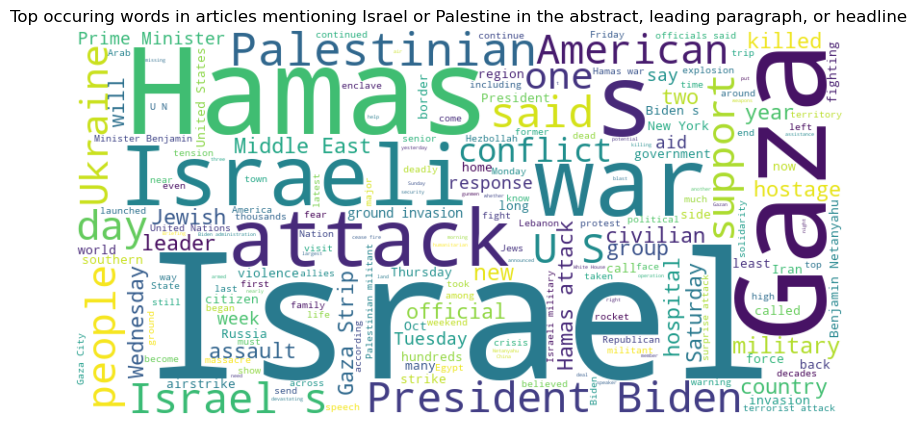

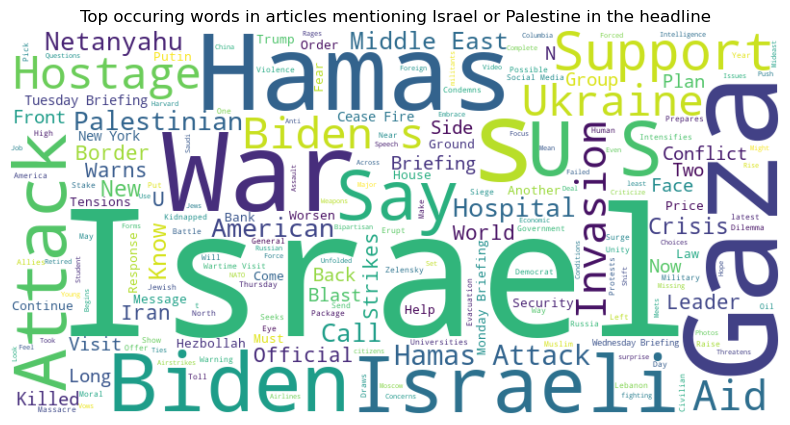

In [205]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all texts into one long string
combined_texts = articles_initial_text_only['all'].str.cat(sep='\n\n')
combined_headlines = articles_initial_text_only['headline'].str.cat(sep="\n")

wordcloudAll = WordCloud(width=800, height=400, background_color="white").generate(combined_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloudAll, interpolation="bilinear")
plt.axis("off") # Turn off the axis
plt.title("Top occuring words in articles mentioning Israel or Palestine in the abstract, leading paragraph, or headline")
plt.show()

wordcloudHeadlines = WordCloud(width=800, height=400, background_color="white").generate(combined_headlines)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloudHeadlines, interpolation="bilinear")
plt.axis("off") # Turn off the axis
plt.title("Top occuring words in articles mentioning Israel or Palestine in the headline")
plt.show()

In [206]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(filtered_texts['all'])

lda = LatentDirichletAllocation(n_components=3, random_state=0)
lda.fit(X)

# Show topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: daughter, held, survivors, lost, khan
Topic 2: israel, gaza, hamas, israeli, war
Topic 3: mother, kibbutz, escape, ali, chappelle


As seen in the generated word cloud, "Hamas" and "Gaza" are much more commonly used in the headlines and abstracts than "Palestine". Interestingly, the word "Palestine" doesn't seem to appear in the word cloud at all, only "Palestinian", although it is not a completely accurate way to gauge the relevancy of the term in the text. Based on the generated topics, many of the articles seem to be focused on the Israeli hostages. Let's use this to refine the search.

In [208]:
# Let's run the search again, this time with more keywords.
# Some of the more common words in the cloud, such as 'Biden', 'Ukraine',
# 'middle east', and 'attack' are excluded as they would most likely bring up unrelated articles.

keywords = ["israel", "palestine", "gaza", "hamas", "netanyahu"]
query = '|'.join(keywords)

dfFiltered = filterArticles(query)
filtered_texts = filterColumns(dfFiltered)

print(len(dfFiltered))

605


# Limitations of the Dataset

Unfortunately, the dataset is incomplete. Since October 2023, the outlet has corrected and in some cases completely removed articles that contained innacuracies (Darcy) - some of them were available through ProQuest's archive, and are included in the game at the end of the notebook. Full articles from the New York Times are also not available to be downloaded in bulk for text mining, making it difficult to analyze their rhetoric in depth. Nevertheless, the data can give us a glimpse into how the articles are framed. Headlines are especially significant due to their visibility. A strong headline can set the tone for the article, succinctly conveying which stories, events, and peoples are worthy of attention. Hence, by choosing to include or exclude certain perspectives in the headline, journalists shape the dominant narrative.

As expected, the size of the data returned almost doubles when the terms "gaza" and "hamas" are included in the search. We now have a fairly large collection of metadata to analyze. Of course, the selection is stil not perfect. The search function is fairly simple, so the relevance of the keywords to each article is unclear. There could also be articles that mention the conflict without using any of these keywords (by referring to specific political figures or simply the Middle East, for example), or articles that discuss the events in later paragraphs. However, the more search terms added, the greater the risk of retrieving unrelated results, so this will have to suffice for now.

# Natural Language Processing on the Metadata

In [209]:
# Use nltk to process the data

import nltk

# Make sure NLTK uses the correct path
nltk.data.path.append("/usr/local/share/nltk_data")

nltk.download('punkt_tab', download_dir='/usr/local/share/nltk_data')
nltk.download('averaged_perceptron_tagger', download_dir='/usr/local/share/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/share/nltk_data')
nltk.download('omw-1.4', download_dir='/usr/local/share/nltk_data')
# nltk.download(download_dir='/usr/local/share/nltk_data') 
    # I ultimately had to use this to get the lemmatizer to work, 
    # but theoretically you shouldn't.

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [210]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import text

stemmer = PorterStemmer()
stop_words = text.ENGLISH_STOP_WORDS

def stemmer_analyzer(doc):
    """
    Text cleaning function
    Tokenizes text and then applies the stemmer to each token
    """
    tokens = word_tokenize(doc)
    pos_tags = pos_tag(tokens)
    return [
        stemmer.stem(t.lower())
        for t, pos in pos_tags
        if t.lower() not in stop_words and t.isalpha() and len(t) > 1
    ]

combined_texts_filtered = filtered_texts['all'].str.cat(sep='\n')
tokens = stemmer_analyzer(combined_texts_filtered)

In [214]:
# Make sure keywords are processed correctly, as the stemmer 
# is bad at recognizing proper nouns

keyword_aliases = {
    "israel": ["israel", "israeli", "isra"],
    "palestine": ["palestine", "palestinian", "palestinians", "palestin"],
    "gaza": ["gazans", "gaza"],
    "hamas": ["hamas", "hama"],
    "netanyahu": ["netanyahu"]
}

variant_to_canonical = {}
for canonical, variants in keyword_aliases.items():
    for v in variants:
        v_tokens = stemmer_analyzer(v)
        variant_to_canonical[" ".join(v_tokens)] = canonical

In [215]:
class word_counts:
    keyCounts = {}
    connections = {}
    def __init__(self, keys, connects):
        self.keyCounts = keys  # Instance attribute
        self.connections = connects  # Instance attribute

def count_words(corpus):
    # Initialize counters
    keywordNum = {k: 0 for k in keywords} 
        # count how many times each keyword appears
    connections = {(k, t): 0 for k in keywords for t in tokens} 
        # count which tokens appear most often with each keyword

    # Iterate over all texts in corpus
    for text in corpus:
        if pd.isna(text):
            continue  # Skip NaNs

        curr_tokens = stemmer_analyzer(text)
        cleaned_headline = " ".join(curr_tokens) 
        curr_tokens = [variant_to_canonical.get(t, t) for t in curr_tokens]
        tokens_set = set(curr_tokens)

        # Find which keywords appear in each headline
        appearing_keywords = []
        for variant, canonical in variant_to_canonical.items():
            if variant in cleaned_headline:
                appearing_keywords.append(canonical)

        # Update counts
        for k in appearing_keywords:
            keywordNum[k] += 1
            for token in tokens_set:
                if token in tokens and token not in keywords:
                    connections[(k, token)] += 1
    my_counts = word_counts(keywordNum, connections)
    return my_counts


/var/folders/jp/11mwm0kx11zgllc8hmpx7mf80000gq/T/ipykernel_10160/2317952369.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords, y=counts, palette="viridis")


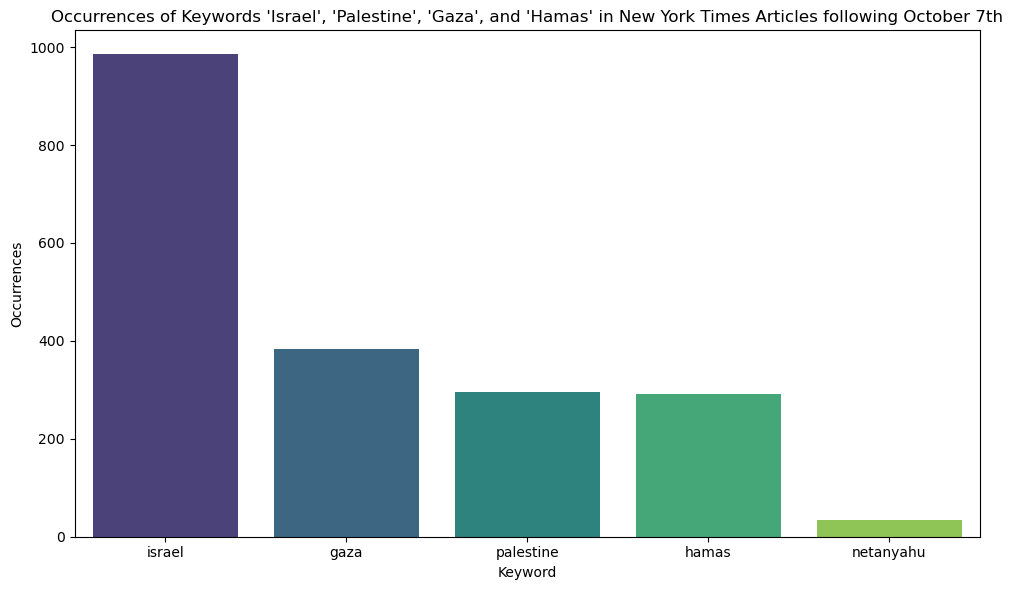

/var/folders/jp/11mwm0kx11zgllc8hmpx7mf80000gq/T/ipykernel_10160/2317952369.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords, y=counts, palette="viridis")


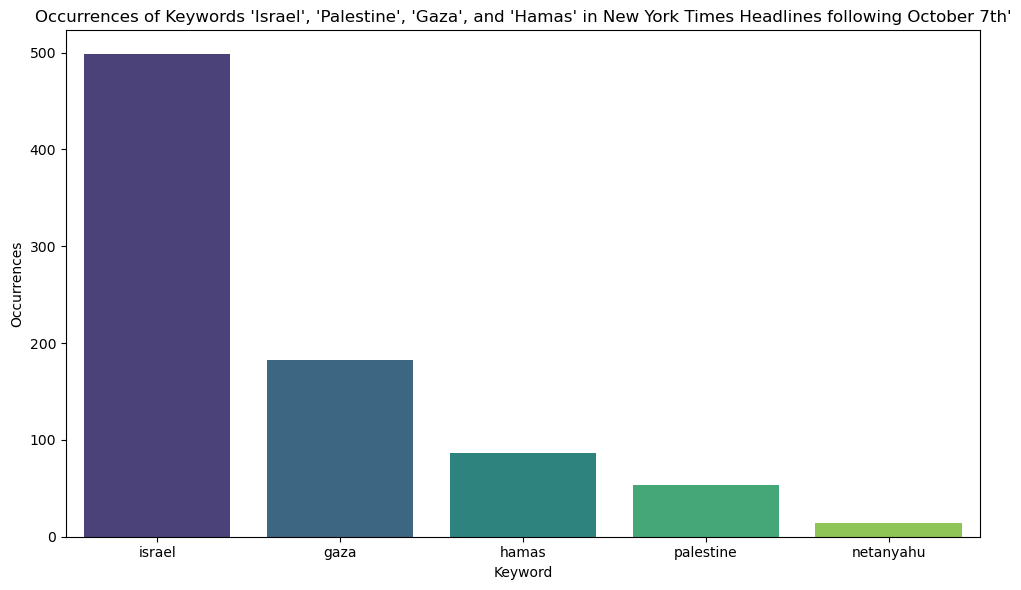

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_keyword_occurrences(my_counts, description):
    keywordNum = my_counts.keyCounts

    sorted_counts = sorted(keywordNum.items(), key=lambda x: x[1], reverse=True)
    keywords, counts = zip(*sorted_counts)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=keywords, y=counts, palette="viridis")
    plt.title(description)
    plt.xlabel("Keyword")
    plt.ylabel("Occurrences")
    plt.tight_layout()
    plt.show()

plot_keyword_occurrences(count_words(filtered_texts['all']), 
                         "Occurrences of Keywords 'Israel', 'Palestine', 'Gaza', and 'Hamas' in New York Times Articles following October 7th")
headline_counts = count_words(filtered_texts['headline'])
plot_keyword_occurrences(headline_counts,
                         "Occurrences of Keywords 'Israel', 'Palestine', 'Gaza', and 'Hamas' in New York Times Headlines following October 7th'")

# Word Count Analysis

A common theme found in headlines following October 7th is the lack of the word "Palestine". Notably, the word "Hamas" appears almost twice as often as "Palestine" in headlines, as shown in the second plot above. When referred to in passing, the conflict is often described as the "Israel-Hamas war" or the "Israel-Gaza war". This word choice is inaccurate at best and dangerous at worst. Palestinian resistance movements have been ongoing inside and outside of the Gaza Strip for long before the 2023 attack, and have involved countless groups besides Hamas (Council on Foreign Relations). The description of the conflict as "Israel-Hamas" or "Israel-Gaza" strips it of its national character, erasing the decades of history in the region and associating all resistance with one radical group. Instead of being treated as a fight for land and self-determination between two peoples, it is turned into an isolated battle between a legitimate country on one hand and a radical, militant group on the other. While "Palestine" is slightly more common than "Hamas" in the overall texts, the fact that "Hamas" is used relatively more frequently in headlines means that for most readers, that is the first impression they receive of the news. Thus, by consistently using "Gaza" and "Hamas" over "Palestine", outlets such as the New York Times de-emphasize Palestinian identity, providing ideological support to the ongoing ethnic cleansing in the region.

In [ ]:
from collections import defaultdict

connections = headline_counts.connections
keyword_connections = defaultdict(dict)
for (kw, token), count in connections.items():
    if count > 0:
        keyword_connections[kw][token] = count

def plot_keyword_cooccurrence(keyword, top_n=10):
    if keyword not in keyword_connections:
        print(f"No data for keyword '{keyword}'")
        return
    
    tokens_counts = keyword_connections[keyword]
    sorted_tokens = sorted(tokens_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    tokens, counts = zip(*sorted_tokens)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=tokens, palette="viridis")
    plt.title(f"Top {top_n} roots co-occurring with '{keyword}'")
    plt.xlabel("Co-occurrence count")
    plt.ylabel("Token")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_keyword_cooccurrence("israel")
plot_keyword_cooccurrence("palestine")
plot_keyword_cooccurrence("hamas")

# Close Reading

The tone in articles about Israel is far more sympathetic, despite Palestinians experiencing more than seven times as many casualties in the time period that the dataset covers (Wilson). Critics have pointed out how western news outlets overuse emotive language and passive voice when talking about Israel. For example, one of the articles, posted on October 8th, is described:

    headline:  "A Shaken Israel Is Forced Back to Its Eternal Dilemma"
    
    abstract: "The attack by Hamas forces Israel once again to confront the conflict that has haunted it since the creation of the modern state."

    leading paragraph: "The most sweeping invasion of Israeli territory in decades, conducted by a Hamas force that had been widely seen as a ragtag collection of militants, has delivered a psychological shock to Israel so great that its very foundations are being questioned: its army, its intelligence services, its government and its capacity to control the millions of Palestinians in its midst."

The vocabulary used in relation to Israel is personal and emotive, as if the author were talking about a person and not a state power. Descriptors such as "shaken", "haunted", and "psychological" carry the connotation of victimhood. The definition of the word "haunted" connotes being tormented by an inhuman force. Additionally, in the last sentence, the phrasing "control the millions of Palestinians in its midst" implies that the Palestinian people are a dangerous force to be subjugated, playing into orientalist stereotypes that generalize Arabs as violent. This implicit categorization others Palestinians, stripping them of their humanity. In contrast to how Israeli suffering is treated, as demonstrated by the second chart, the words used in conjunction with "Palestine" are much more militaristic, with terms like "violence," "blast," and "strike," weaving a gruesome tapestry. It could be that the  articles also deal with violence inflicted on Gaza, as the co-occurrence matrix does not take into account context. But regardless, the overly militaristic word choice reflects that the outlet's descriptions of violence do not afford Palestinians the same empathy as Israelis for the horrors that they both face. Attacks on Palestinians are reported on in a more matter-of-fact way without delving into their perspective. Together, the language creates a narrative in which Israelis are the victims and Palestinians are the evil which they must be shielded from. 

The New York Times's word choice not only victimizes Israel but places the United States in the position of its protector. "Biden" stands out as the top co-occurrence in the chart "Top 10 roots co-occurring with 'Israel.'" Verbiage such as "support" and "aid" is presented as a moral imperative. President Biden, in headlines, is often called upon to help or criticized for not doing enough. In this way, news coverage of the conflict reinforces the intimate relationship between Israel and the U.S. By erasing Palestinian statehood, presenting them as alien, and placing Israel in close proximity to Americans, news coverage of the war between Israel and Palestine helps manufacture consent for the U.S.'s involvement.

# Python Class: Headline Guesser

Now it's your turn to play around! HeadlineGuesser is an interactive class that, when prompted, starts a game in which you as the user will be given a series of quotes. Some of the quotes are taken from fictional novels that deal with themes of war, and some are headlines from real opinion pieces published in the New York Times about the Israel-Palestine conflict, with some of the words changed to make it less obvious. Your task is to guess which is which.

In [ ]:
import random

class HeadlineGuesser():
    def __init__(self):
        self.user_score = 0
        self.bot_score = 0
        self.guesses = 0
        self.input_map = {"NYT": True, "FAKE NEWS": False}

        
        headlines_game_json = pd.read_json("headlines_game.json")
        self.headlines_game_df = pd.DataFrame(headlines_game_json)
        self.headlines_game_df['guessed'] = False
        self.max_guesses = len(self.headlines_game_df)

        print("I'm going to give you a quote.\n" + \
                "Your job is to guess whether it the headline of a New York Times op-ed piece or a quote from a fictional piece of media.\n" + \
                "Reply 'NYT' if you think it's a real headline and 'FAKE NEWS' if you think it's fictional.\n" + \
                "Reply 'STOP' at any time to end the game.\n" + \
                "Let's practice. Reply with 'NYT' if you're ready to start.\n")
        user_input = input("Enter your response: ")
        
        if user_input == "NYT": 
            print("Great! Let's get started.\n")
            self.run_game()
        else:
            self.end()
    
    def end(self):
        print("Player score: " + str(self.user_score) + \
              "\nBot score: " + str(self.bot_score) + \
              "\nThank you for playing!")
            
    # Main body of the bot
    def run_game(self):
        while self.guesses != self.max_guesses:
            self.guesses += 1

            # Find quote that hasn't been played yet
            rand = random.randint(0, len(self.headlines_game_df) - 1)
            while self.headlines_game_df.loc[rand, "guessed"] == True:
                rand = random.randint(0, len(self.headlines_game_df) - 1)

            user_input = self.prompt(rand)
            self.headlines_game_df.loc[rand, "guessed"] = True
            if user_input == "STOP":
                self.end()
                return

        self.end()
        

    # Function that prompts user with quote
    def prompt(self, i):
        # Prompt user
        quote = self.headlines_game_df.iloc[i, 0]
        is_real = self.headlines_game_df.iloc[i, 1]
        print(f'Quote: "{quote}"')
        user_guess = input("Enter your response: ")
        if user_guess == "STOP":
            return user_guess
        elif (self.input_map[user_guess] == is_real):
            self.user_score += 1
            print("Great job, you got it right!")
            if (is_real == True):
                print(f"Here's the real title: '{self.headlines_game_df.iloc[i, 2]}'\n")
            else:
                print(f"The quote is actually from: {self.headlines_game_df.iloc[i, 2]}\n")
        else:
            self.bot_score += 1
            print("Nope, better luck next time!")
            if (is_real == True):
                print(f"Here's the real title: '{self.headlines_game_df.iloc[i, 2]}'\n")
            else:
                print(f"The quote is actually from: {self.headlines_game_df.iloc[i, 2]}\n")

In [ ]:
# Uncomment when you're ready to play the game!
# HeadlineGuesser()

# Works Cited

Brenan, M. (2025, March 27). Less than half in U.S.. now sympathetic toward Israelis. Gallup.com. https://news.gallup.com/poll/657404/less-half-sympathetic-toward-israelis.aspx

Council on Foreign Relations. (2025, June 24). Israeli-palestinian conflict timeline. Council on Foreign Relations. https://education.cfr.org/learn/timeline/israeli-palestinian-conflict-timeline 

Darcy, O. (2023, October 26). The New York Times walks back flawed Gaza hospital coverage, but other media outlets remain silent | CNN business. CNN. https://www.cnn.com/2023/10/24/media/gaza-hospital-coverage-walk-back 

Wilson, R., deAcostaNoya, R., Matthews, A. L., & Newman, A. (2023, November 7). One month’s death toll in the Israel-hamas war, in charts. CNN. https://www.cnn.com/2023/11/07/middleeast/palestinian-israeli-deaths-gaza-dg 